In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import numpy as np
%matplotlib inline
pd.options.display.max_rows = 10
pd.options.display.max_columns = 100

# DATA IMPORTATION AND PRE-PROCESSING

In [8]:
'''Importation '''

columns_to_import = ['DATE','CSPL_RECEIVED_CALLS','ASS_ASSIGNMENT']
df = pd.read_csv(	"train_2011_2012_2013.csv", delimiter = ';',usecols=columns_to_import ,nrows=10878470)
submission = pd.read_csv(	"submission.txt", delimiter = '\t')
Holidays = pd.read_csv(	"jour_ferie.txt", sep='\t')
Holidays["is_ferie"] = 1
submission_saved = submission

In [9]:
'''Show the first row'''
df[:1]

,DATE,ASS_ASSIGNMENT,CSPL_RECEIVED_CALLS
0,2011-04-24 01:30:00.000,Téléphonie,0


In [10]:
'''Convert to Date time'''
df['DATE'] = pd.to_datetime(df['DATE'])
submission['DATE'] =  pd.to_datetime(submission['DATE'])

'''create a dictionnary with all ASS_ASSIGNMENT names for submission'''
list_assignment2 = list(pd.get_dummies(submission['ASS_ASSIGNMENT']))
dictionnary = dict((list_assignment2[i],i) for i in range(len(list_assignment2))) # creating a dictionay mapping

#We pre-process the data, by replacing ASS_ASSIGMENT by a value
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(list_assignment2)
list(le.classes_)
le.transform(['CAT','Gestion DZ'])
list(le.inverse_transform([2, 2, 1]))
le.classes_

array(['CAT', 'CMS', 'Crises', 'Domicile', 'Gestion',
       'Gestion - Accueil Telephonique', 'Gestion Assurances',
       'Gestion Clients', 'Gestion DZ', 'Gestion Relation Clienteles',
       'Gestion Renault', 'Japon', 'Manager', 'Mécanicien', 'Médical',
       'Nuit', 'Prestataires', 'RENAULT', 'RTC', 'Regulation Medicale',
       'SAP', 'Services', 'Tech. Axa', 'Tech. Inter', 'Tech. Total',
       'Téléphonie'], 
      dtype='<U30')

In [11]:
'''plot function'''
keys = ['ASS_ASSIGNMENT == "'+list(dictionnary.keys())[i]+'"' for i in range(len(dictionnary.keys()))]
names = ['Crises', 'Domicile', 'CAT', 'CMS', 'RTC', 'Gestion DZ', 'Regulation Medicale', 'Nuit', 'Medical', 'Gestion Renault', 'Gestion - Accueil Telephonique', 'Services', 'SAP', 'Prestataires', 'RENAULT', 'Gestion', 'Gestion Clients', 'Tech. Inter', 'Tech. Total', 'Telephonie', 'Manager', 'Japon', 'Gestion Relation Clienteles', 'Tech. Axa',
 'Mecanicien', 'Gestion Assurances']
def plot_average_calls_per_cat(df_24h):
    fig, axes = plt.subplots(figsize = (20,15),nrows=6, ncols=5)
    for i in range(len(keys)):
        ax = df_24h.query(keys[i]).plot(subplots=True, figsize=(4,4),ax=axes[int(i/5),i - int(i/5)*5], legend = False, xticks =[],
                                         sharex  = True)
        ax[0].set_title(names[i])

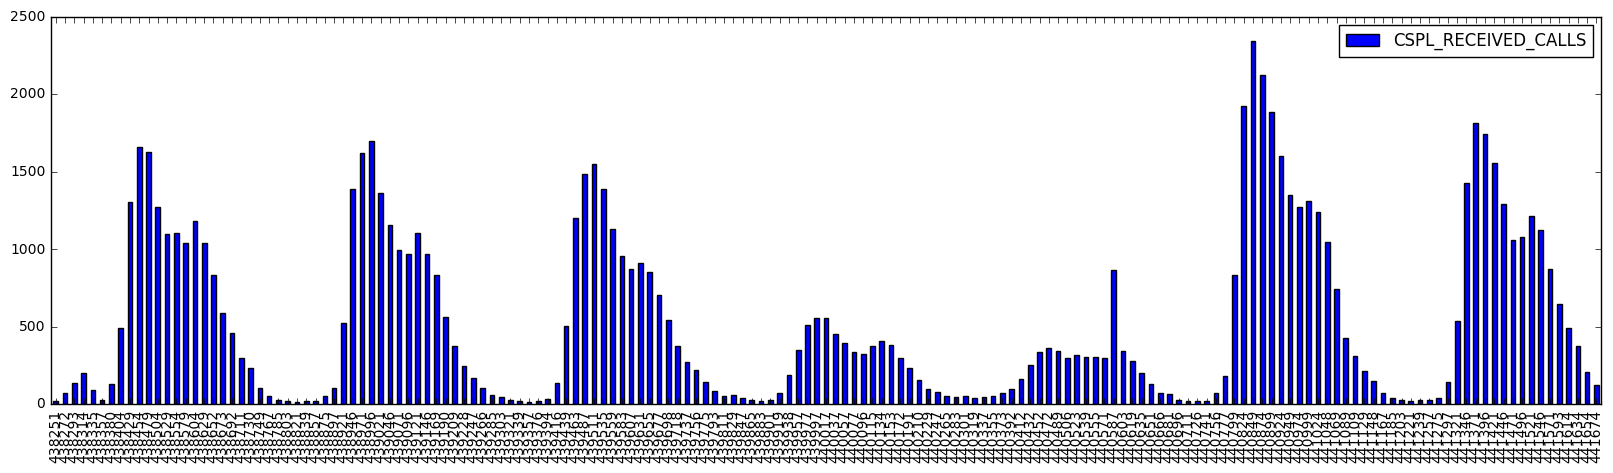

In [12]:
nb_appels_per_cat = df[['DATE','CSPL_RECEIVED_CALLS', 'ASS_ASSIGNMENT']].groupby([pd.Grouper(freq ='h', key='DATE'),'ASS_ASSIGNMENT']).sum().reset_index()
nb_appels_per_cat.query('ASS_ASSIGNMENT == "Téléphonie"').\
                query("(DATE > '2013-06-05 00:00:00') ").query("(DATE < '2013-06-13 23:00:00') ").plot(kind='bar',figsize = (20,5))

Dayly evolution of total number of calls per category


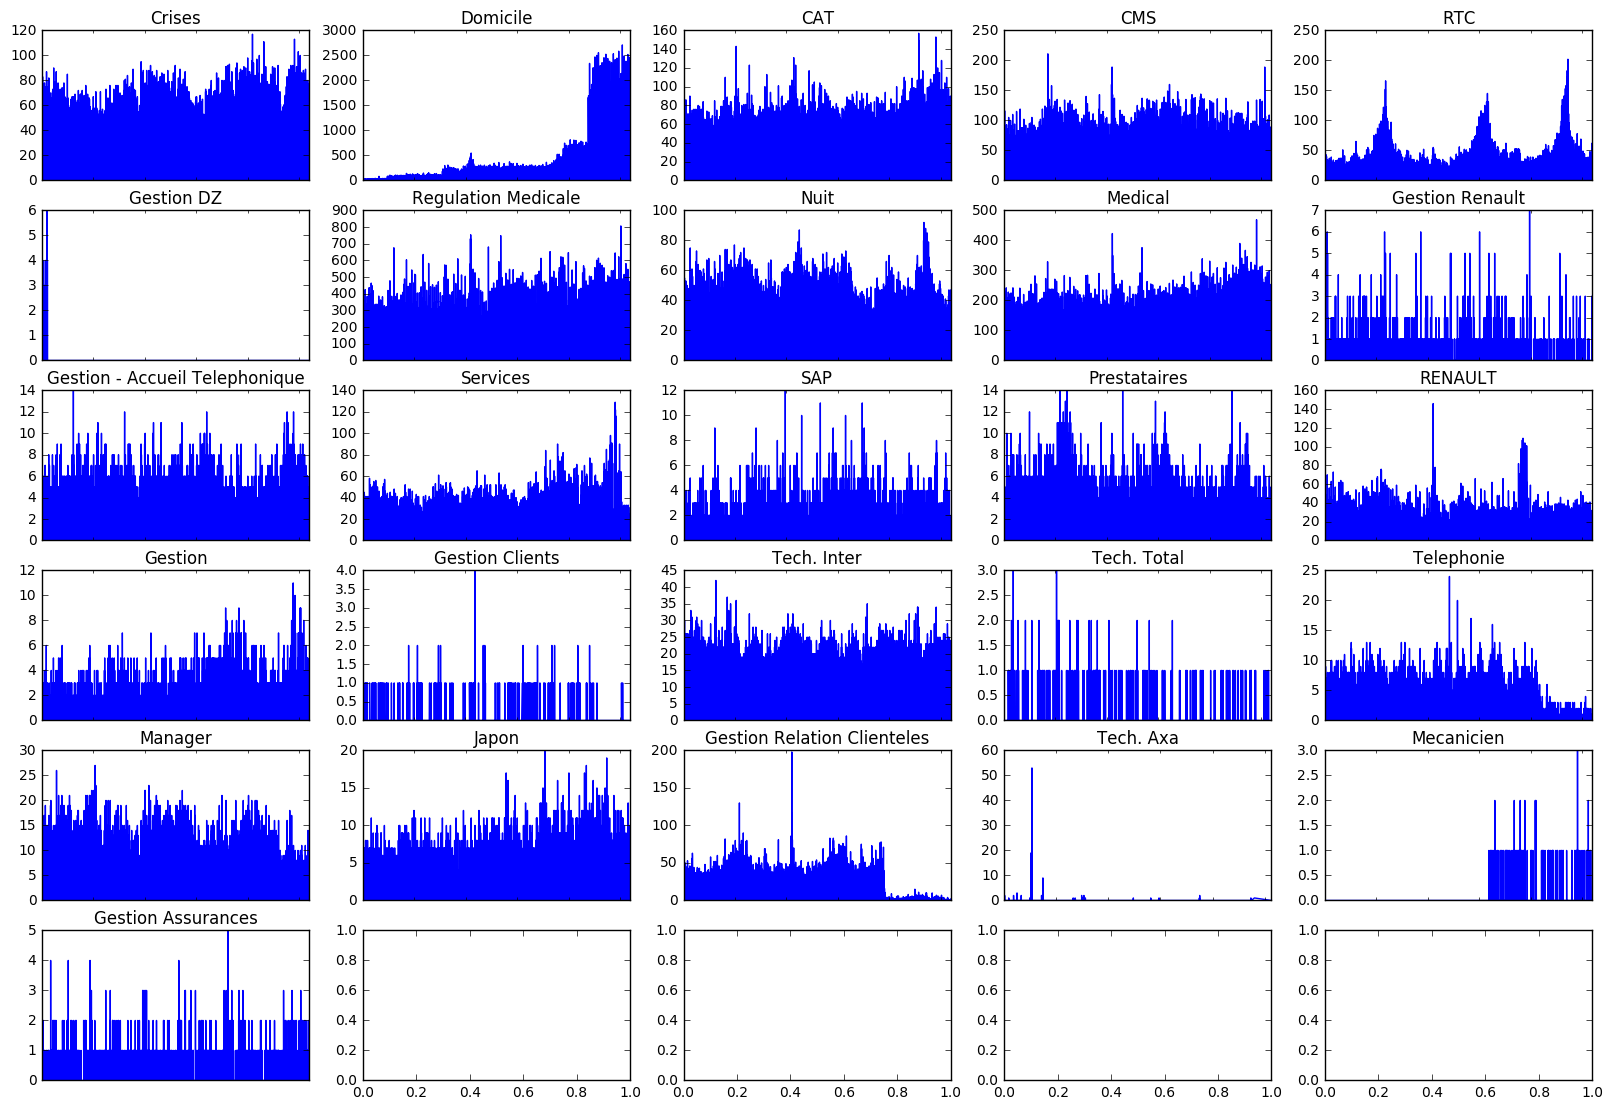

In [14]:
plot_average_calls_per_cat(nb_appels_per_cat.query("(DATE > '2011-01-01 23:00:00') ").query("(DATE < '2013-12-31 23:00:00') "))
print("Dayly evolution of total number of calls per category")

We see that number of calls fluctates quite a lot over two years (2011 / 2012) 
Reducing the training set on the last 6 months can be valuable for most of the categories. 

# Feature engineering 

In [15]:
def add_ferie(X,Holidays):
    is_ferie =X.merge(Holidays.drop_duplicates(subset=['YEAR','MONTH','DAY_nb']), on=['YEAR','MONTH','DAY_nb'], how='left')['is_ferie'].fillna(0).reset_index()['is_ferie']
    return  pd.concat((X.reset_index(), is_ferie ), axis =1)

In [16]:
def preparing_vector_X():
    '''Vecteur X'''
    X = df[['DATE','CSPL_RECEIVED_CALLS','ASS_ASSIGNMENT']]
    X = X.groupby(['DATE', 'ASS_ASSIGNMENT']).sum().reset_index() #- > this stage, my first guess is to sum duplicates
    submission = submission_saved
    
    '''dropping not used ASS_ASSIGNMENT'''
    to_drop = ['Gestion Amex','Evenements']
    X = X[~X.ASS_ASSIGNMENT.isin(to_drop)] ##droping string values not in submission
    X1= X #X saved
    submission_saved2 = submission #submission saved

    '''Splitting DATE into features'''
    X['YEAR'] = X['DATE'].dt.year
    X['MONTH'] = X['DATE'].dt.month
    X['DAY'] = X['DATE'].dt.dayofweek
    X['DAY_nb'] = X['DATE'].dt.day
    X['HOUR'] = X['DATE'].dt.hour
    X['MIN'] = X['DATE'].dt.minute
    X['WEEK'] = X['DATE'].dt.week
    X['TIME'] = X['DATE'].dt.time
    submission['YEAR'] = submission['DATE'].dt.year
    submission['MONTH'] = submission['DATE'].dt.month
    submission['DAY'] = submission['DATE'].dt.dayofweek
    submission['DAY_nb'] = submission['DATE'].dt.day
    submission['HOUR'] = submission['DATE'].dt.hour
    submission['MIN'] = submission['DATE'].dt.minute
    submission['WEEK'] = submission['DATE'].dt.week
    submission['TIME'] = submission['DATE'].dt.time
    
#     submission = add_ferie(submission,Holidays)
    
    return X,submission

def prepapre_vector_X2():
    X,submission = preparing_vector_X()
    submission = add_ferie(submission,Holidays)
    X = add_ferie(X,Holidays)
    return X,submission


In [17]:
X,submission = prepapre_vector_X2()

'''LINEX Loss function for evaluation'''
def loss_funtion(y1,y2,alpha=0.1):
    return np.exp(alpha*(y1-y2)) - alpha* (y1 - y2) -1 

def loss_funtion_average(y1,y2,alpha=0.1):
    return loss_funtion(y1,y2,alpha).mean()

In [18]:
'''Prediction'''
def fn_prediction(Y):
    return  np.maximum(np.zeros(Y.shape[0]),np.ceil(Y)) 

In [19]:
def plot_errors(col, data_test,labels_test,labels_predicted):
    loss_plot = pd.DataFrame(loss_funtion(labels_test,labels_predicted))
    loss_plot = pd.concat([pd.DataFrame(data_test),pd.DataFrame(labels_test),pd.DataFrame(labels_predicted),loss_plot], axis = 1)
    loss_plot = pd.DataFrame(loss_plot.values , columns = col +["True"]+["Predicted"]+["Loss"])
    return loss_plot.sort_values('Loss', ascending=False)
# errors = plot_errors(data_test,labels_test,labels_predicted)
# errors

# First version - CV pipeline + Trees ensembles

In [22]:
'''Defining the beginning of each submission week'''
start_test = submission[~submission[['YEAR','MONTH']].duplicated()].drop(submission.index[3747])['DATE']
start_weeks = submission[~submission[['YEAR','MONTH']].duplicated()].drop(submission.index[3747])['DATE']

In [23]:
'''For each week to predict, we split training and cv data as below '''
start_train = start_weeks- pd.Timedelta(days=365)  
end_train = start_weeks-  pd.Timedelta(days=7) 
start_cv = start_weeks - pd.Timedelta(days=7) 
end_cv = start_weeks 

In [24]:
# del submission_file_final
submission_file_final = []
errors_cv = []
import pdb
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# reg =GradientBoostingRegressor(n_estimators=100,max_depth=25)
# reg = DecisionTreeRegressor(max_depth=50)
reg = RandomForestRegressor( n_estimators=10)

# reg = GradientBoostingRegressor()
# reg.set_params(**{'min_samples_split': 20, 
#                                  'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 30
#                  })

resultat_final = np.zeros((2,12))

for i in range(len(start_train)): #
    columns_for_training = ['MONTH','DAY','HOUR','MIN']+list(le.classes_)

    '''Dummy coding'''
    X_final = pd.concat( [X,pd.get_dummies(X['ASS_ASSIGNMENT']) ] , axis = 1)
    X_cv = pd.concat( [X,pd.get_dummies(X['ASS_ASSIGNMENT']) ] , axis = 1)
    X_submission = pd.concat( [submission,pd.get_dummies(submission['ASS_ASSIGNMENT']) ] , axis = 1)

    X_final=X_final.loc[(X_final['DATE']>=start_train.values[i])&(X_final['DATE']<start_cv.values[i])]
    X_cv=X_cv.loc[(X_cv['DATE']>=start_cv.values[i])&(X_cv['DATE']<end_cv.values[i])]

    X_submission = X_submission.loc[(X_submission['DATE']>=start_test.values[i])&(X_submission['DATE']<( start_test + pd.Timedelta(days=8) ).values[i])]
    X_submission_saved = X_submission
    X_cv_saved = X_cv
    
    Y_final = X_final['CSPL_RECEIVED_CALLS']
    X_final = X_final[columns_for_training]
    Y_cv = X_cv['CSPL_RECEIVED_CALLS']
    X_cv = X_cv[columns_for_training]
    X_submission = X_submission[columns_for_training]

    Y_cv_array = np.array(Y_cv.values)
    X_cv_array = np.array(X_cv.values)
    Y_array = np.array(Y_final.values)
    X_array = np.array(X_final.values)
    X_submission_array = np.array(X_submission)

    reg.fit(X_array,Y_array)
    
    submission_predicted = pd.DataFrame(fn_prediction(reg.predict(X_submission_array))  ,columns=['prediction']) 
    labels_predicted_cv = fn_prediction( reg.predict(X_cv_array))   
    errors_cv.append (plot_errors(columns_for_training, X_cv_array,Y_cv_array,labels_predicted_cv))

    resultat_final[0,i]  = loss_funtion_average(Y_array, fn_prediction( reg.predict(X_array))  )
    resultat_final[1,i]  = loss_funtion_average(Y_cv_array, labels_predicted_cv )
    
    print ( "---------------- CV Week of Month : %.d -----------------------------------" % (i +1) )
    print ( "Error on TRAIN : %.2e" %resultat_final[0,i] )
    print ( "Error on CV : %.2e" %resultat_final[1,i])
    
    df_results = pd.DataFrame(resultat_final, columns=["week %d" %(j+1) for j in range(12)])
    
    '''Creating the submission file'''

    submission_file = pd.concat([X_submission_saved[['DATE','ASS_ASSIGNMENT']].reset_index(), submission_predicted],axis =1)
    submission_file['DATE'] = submission_file['DATE'].astype(str) + '.000'
    if i == 0 : 
        submission_file_final = submission_file.values 
    else : 
        submission_file_final = np.concatenate((submission_file_final,submission_file.values) )

    df_final = pd.DataFrame(submission_file_final[:,1:], columns=['DATE', 'ASS_ASSIGNMENT', 'prediction'])
    
'''saving file '''
file_name = "submission"+str(datetime.datetime.now().strftime('%Y%m%d %H%M%S'))+".txt"
df_final.to_csv(	file_name, header=True, index=None, sep='\t', mode='a')

---------------- CV Week of Month : 1 -----------------------------------
Error on TRAIN : 6.78e+04
Error on CV : 1.28e+01
---------------- CV Week of Month : 2 -----------------------------------
Error on TRAIN : 2.20e+04
Error on CV : 3.36e+03
---------------- CV Week of Month : 3 -----------------------------------
Error on TRAIN : 2.15e+04
Error on CV : 1.63e+08
---------------- CV Week of Month : 4 -----------------------------------
Error on TRAIN : 5.04e+04
Error on CV : 6.54e+07
---------------- CV Week of Month : 5 -----------------------------------
Error on TRAIN : 6.05e+02
Error on CV : 1.50e+09
---------------- CV Week of Month : 6 -----------------------------------
Error on TRAIN : 2.44e+03
Error on CV : 8.24e+38
---------------- CV Week of Month : 7 -----------------------------------
Error on TRAIN : 3.77e+26
Error on CV : 4.15e+30
---------------- CV Week of Month : 8 -----------------------------------
Error on TRAIN : 6.53e+26
Error on CV : 3.23e+27
----------------

In [25]:
'''Here we can investiguate were the errors were made on CV'''
errors_cv[5].head(n=10)

,MONTH,DAY,HOUR,MIN,CAT,CMS,Crises,Domicile,Gestion,Gestion - Accueil Telephonique,Gestion Assurances,Gestion Clients,Gestion DZ,Gestion Relation Clienteles,Gestion Renault,Japon,Manager,Mécanicien,Médical,Nuit,Prestataires,RENAULT,RTC,Regulation Medicale,SAP,Services,Tech. Axa,Tech. Inter,Tech. Total,Téléphonie,True,Predicted,Loss
5226,6.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1170.0,192.0,2.978519e+42
5251,6.0,0.0,10.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1171.0,194.0,2.695075e+42
5276,6.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1078.0,205.0,8.201783e+37
5201,6.0,0.0,9.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1077.0,209.0,4.974633e+37
5301,6.0,0.0,11.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1049.0,200.0,7.440490e+36
5326,6.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,971.0,163.0,1.233088e+35
5351,6.0,0.0,12.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,914.0,120.0,3.040758e+34
1564,6.0,3.0,11.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,875.0,95.0,7.498417e+33
536,6.0,2.0,11.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,852.0,104.0,3.056520e+32
5376,6.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,864.0,126.0,1.124431e+32


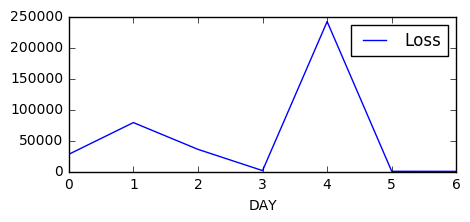

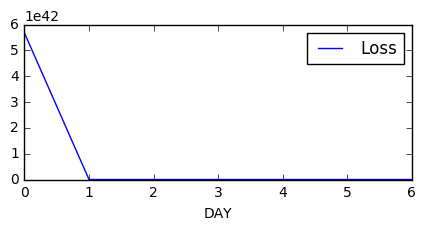

In [26]:
'''Error PLot'''

loss_concat = pd.concat(([errors_cv[i] for i in range(1,12)]), axis =0).reset_index()

x1 = loss_concat.loc[(loss_concat['CAT']==1)][['DAY','Loss']].groupby(['DAY']).sum()
x2 = loss_concat.loc[(loss_concat['Tech. Axa']==1)][['DAY','Loss']].groupby(['DAY']).sum()
x3 = loss_concat.loc[(loss_concat['Téléphonie']==1)][['DAY','Loss']].groupby(['DAY']).sum()
# x1.plot(x= "DAY", y="Loss", figsize=(5,2), title='CAT')
# x2.plot(x= "DAY", y="Loss", figsize=(5,2), title='Tech Axa')
# x3.plot(x= "DAY", y="Loss", figsize=(5,2), title='Telephonie')
x2.plot(figsize=(5,2))
x3.plot(figsize=(5,2))

# SECOND trial - Optimizing  the Linex loss function 

On this section, we are going to try to reformulate the problem with taking into account the Linex loss function. 

#### a_ Optimization Formulation

Supposing that we  want to find a linear solution for our problem. We would have to minimize the function below : 

$ \min_{(\theta)} F(\theta) = \frac{1}{n} \sum_{i=1}^{n} linex(y_{i} , \theta^{\top}x_{i}) = \frac{1}{n}
\sum_{i=1}^{n} exp(\alpha (y_{i} - \theta^{\top}x_{i}) ) - \alpha(y_{i} - \theta^{\top}x_{i}) $

The derivative of this function is : 

$ \frac{\partial F}{\partial \theta} = \frac{\alpha}{n}
\sum_{i=1}^{n} [1 - exp(\alpha (y_{i} - \theta^{\top}x_{i})] x_{i}^{\top}  $

Having written those two functions, we will use a L-BFGS descent to find the minimum.

For a first trial, we are going to assume that our features are only the Hours&Minutes timestamps. 
For that we split our training data set per ASS_ASSIGNMENT & DAY. 
Eg. for a Monday on Téléphonie, the value retained for prediction will depend only on the Hour:Minute.

#### b_ Results 

With the same pipeline defined and a 365 days of training set before each submission week, we obtain an errors of 1143. It was so far the best result we had as before it was "exploding" due to the nature of the loss function.

In [28]:
from scipy.optimize import fmin_l_bfgs_b

'''We create a class that is containing the loss function and the gradients functions'''
class Loss(object):
    """class for Optimization Second Trial """

    def __init__(self, X, Y, alpha):
        self.X = X
        self.Y = Y
        self.n, self.d = X.shape
        self.alpha = alpha

    def function_(self, theta):
        return 1./ self.n * sum([loss_funtion(self.Y[i], np.dot(self.X[i].T, theta)) for i in range(self.n)])

    def grad_(self, theta):
        aux = np.zeros(self.d)
        
        for i in range(self.n):
            aux_i = 1 - np.exp(self.alpha* (self.Y[i] - np.dot(self.X[i].T, theta) ))
            aux +=  aux_i * self.X[i].T
        return aux / self.n * self.alpha
    
    def grad_i(self, theta, i):
        aux_i = (1 - np.exp(self.alpha* (self.Y[i] - np.dot(self.X[i].T, theta) )) )* self.X[i].T 
        return aux_i* self.alpha


In [29]:
'''function that inspects LBFGS'''
def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk) 
#         err = norm(xk - x_min)
        objectives.append(obj)
#         errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
            if it[0] % (max_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8)])) #, ("%.2e" % err).rjust(8)
            it[0] += 1
    inspector_cl.obj = objectives
#     inspector_cl.err = errors
    return inspector_cl

#### Prediction for Loss Optimum

In [30]:
'''Returns Data and Labels array for training for a specif day and category'''
def prepare_data(X,jour = 0,categorie = le.classes_[0]):
    X_CAT = X[(X['ASS_ASSIGNMENT'] == categorie)&(X['DAY'] == jour)]
    Data = np.array(pd.get_dummies(X_CAT['TIME']).values)
    List = list(pd.get_dummies(X_CAT['TIME']))
    Labels = np.array(X_CAT['CSPL_RECEIVED_CALLS'].values)
    return Data, Labels, List

In [31]:
Data, Labels, List =prepare_data(X,jour = 0,categorie = le.classes_[0])
model = Loss(Data, Labels, alpha= 0.1)

In [65]:
Df_final2 = pd.DataFrame()
final_submission = pd.DataFrame()
for i in range(len(start_train)): #date
    submission_period = submission.loc[(submission['DATE']>=start_test.values[i])&(submission['DATE']<( start_test + pd.Timedelta(days=8) ).values[i])]
    list_cat = submission_period.groupby(['ASS_ASSIGNMENT']).count().index.values.tolist()
    submission_period['Prediction Week'] = i
    
    for cat in list_cat:
        for j in range(7):
            Data, Labels, List = prepare_data(X.loc[(X['DATE']>=start_train.values[i])&(X['DATE']<end_train.values[i])],jour = j,categorie = cat)
            if Labels.size > 0 : 
                model = Loss(Data, Labels, alpha= 0.1)

                max_iter = 1000
                x_init = 100* np.zeros(Data.shape[1])
                lbfgs_inspector = inspector(model.function_, x_init, verbose=False)
                start = time.clock()
                theta_lbfgs,_,_ = fmin_l_bfgs_b(func = model.function_, x0= x_init, fprime= model.grad_,  maxiter=max_iter,
                                             callback=lbfgs_inspector)
        #         print ("Time for Descent : %.2f " %(time.clock() - start))

                Df_final = pd.DataFrame(data=np.vstack((np.array(List),theta_lbfgs)).T,columns= ['TIME','prediction'])
                Df_final['ASS_ASSIGNMENT'] = cat
                Df_final['Prediction Week'] = i
                Df_final['DAY'] = j

                Df_final2 = Df_final2.append(Df_final)
    final_submission = final_submission.append(submission_period)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [66]:
FINAL = final_submission.reset_index().merge(Df_final2,left_index = True,how= 'left', on=['TIME','ASS_ASSIGNMENT','Prediction Week','DAY']).set_index('index')[['DATE','ASS_ASSIGNMENT','prediction_y']]
FINAL.loc[FINAL.loc[(pd.isnull(FINAL['prediction_y'] ))].index,'prediction_y'] = 0


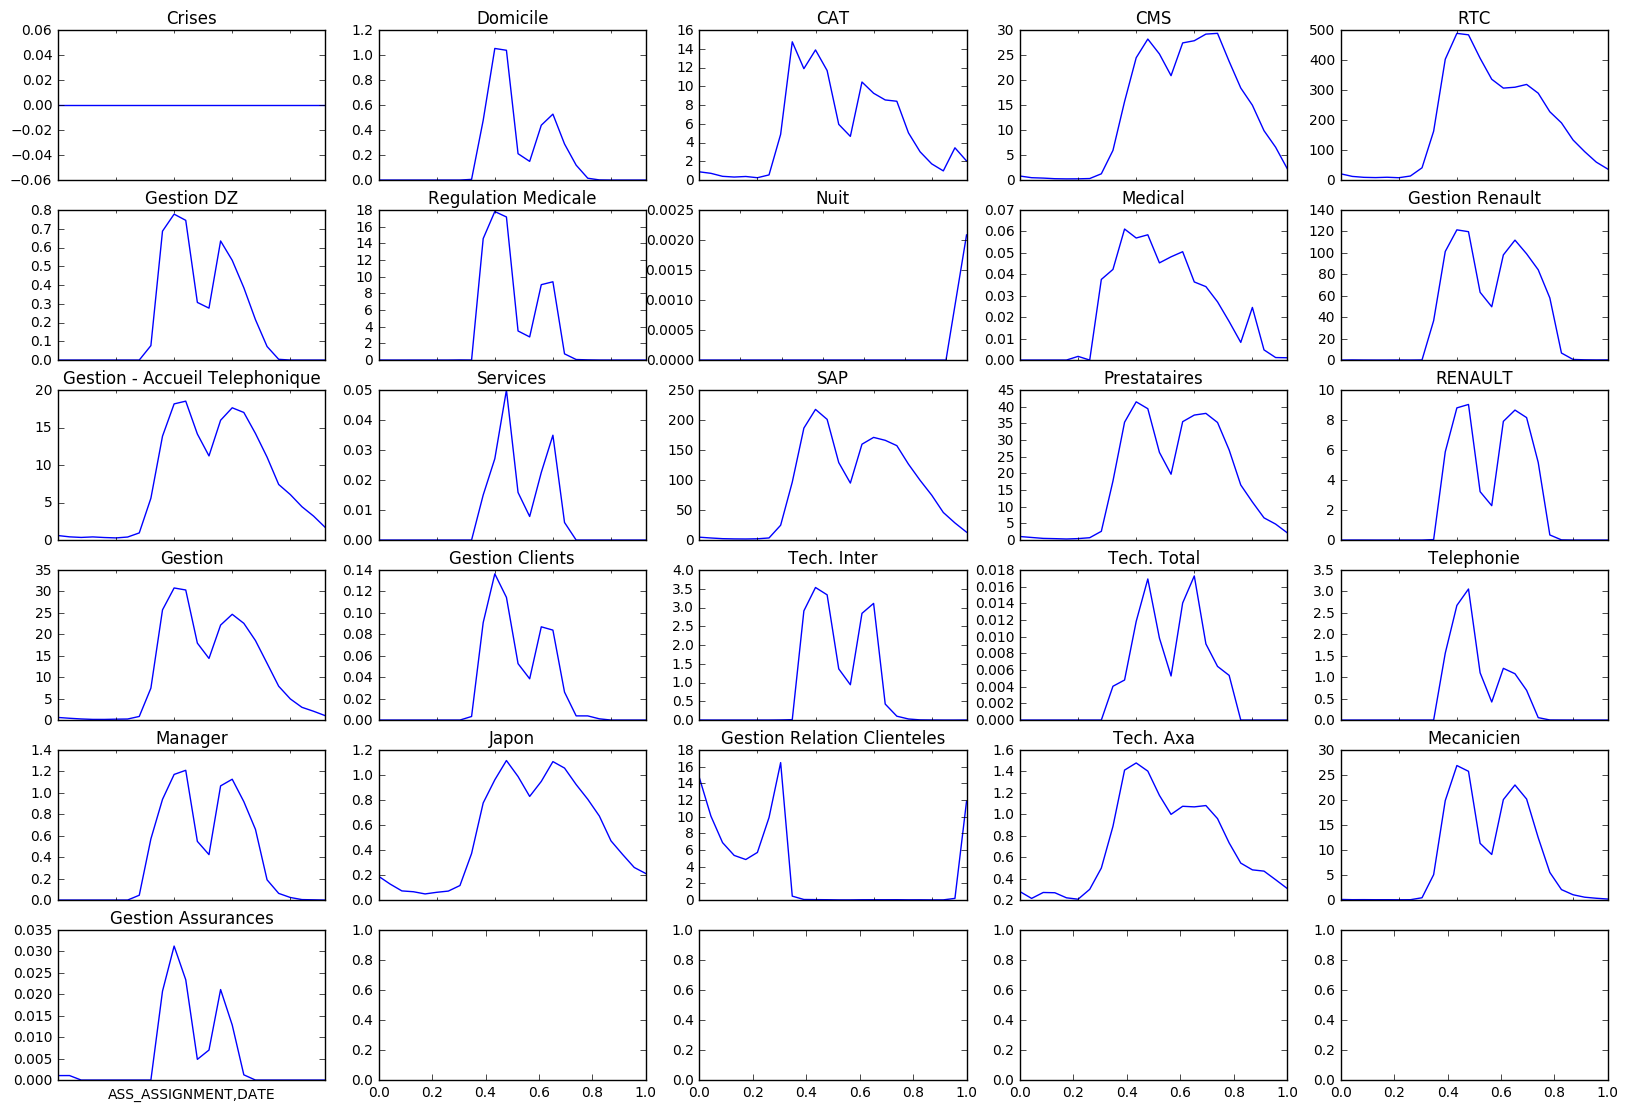

In [67]:
FINAL['DATE'] = pd.to_datetime(FINAL['DATE'])
FINAL.prediction_y=FINAL.prediction_y.astype(float)
nb_appels_24h_predicted = FINAL[['DATE','prediction_y','ASS_ASSIGNMENT']].groupby(['ASS_ASSIGNMENT',FINAL["DATE"].dt.hour]).mean()
plot_average_calls_per_cat(nb_appels_24h_predicted)

In [68]:
file_name = "submission"+str(datetime.datetime.now().strftime('%Y%m%d %H%M%S'))+".txt"
FINAL['DATE'] = FINAL['DATE'].astype(str) + '.000'
FINAL.to_csv(	file_name, header=True, index=None, sep='\t', mode='a')

In [ ]:
FINAL['DATE'] = pd.to_datetime(FINAL['DATE'])
nb_appels_week_predicted = FINAL[['DATE','prediction_y','ASS_ASSIGNMENT']].groupby(['ASS_ASSIGNMENT',FINAL["DATE"].dt.dayofweek]).mean()
plot_average_calls_per_cat(nb_appels_week_predicted)

# THIRD VERSION - ParameterGrid Search with custom loss - XGBoost


In this part we use ParameterGrid to fine tune the regressors parameters and especially  Gradient Boosting and XGboost with a custom loss. The function ParamterGrid is prefered over GridSearch because it does not use K-fold for cross validation and leaving trainnig untouched.


In [273]:
from sklearn.ensemble import GradientBoostingRegressor

models2 = { 
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
}

             ]
params_GBR = [{ 'n_estimators': range(80,141,20), 
               'learning_rate': [0.1, 0.5 , 1.0] ,
              'max_depth':range(5,16,5), 
               'min_samples_split':range(200,1000,2200000),
               'min_samples_leaf':range(30,71,10),
              } ]

params_XGBoost = [{'n_estimators': range(180,201,20),
               'learning_rate': [0.1, 0.5] ,
              'max_depth':range(15,21,5),
                  }]  


In [8]:
start_test = submission[~submission[['YEAR','MONTH']].duplicated()].drop(submission.index[3747])['DATE']
start_weeks = submission[~submission[['YEAR','MONTH']].duplicated()].drop(submission.index[3747])['DATE']

In [248]:
'''For each week to predict, we split training and cv data as below '''
# Small training set get 30 days 
# Larger training set get 365 days

start_train = start_weeks- pd.Timedelta(days=37) #-  pd.Timedelta(days=365)
end_train = start_weeks-  pd.Timedelta(days=7)  #-  pd.Timedelta(days=365)
start_train_2 = start_weeks- pd.Timedelta(days=385)  #-  pd.Timedelta(days=365)
end_train_2 = start_weeks-  pd.Timedelta(days=355) #-  pd.Timedelta(days=365)
start_cv = start_weeks - pd.Timedelta(days=7) #-  pd.Timedelta(days=365)
end_cv = start_weeks #-  pd.Timedelta(days=365)

In [12]:
from sklearn.metrics.scorer import make_scorer
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import ParameterGrid

# my_scorer = make_scorer(loss_funtion_average, greater_is_better=True)

In [ ]:

submission_file_final = []
errors_cv = []
import pdb
from sklearn.ensemble import GradientBoostingRegressor


X = preparing_vector_X()
params_choice = []

for params in list(ParameterGrid(params_GBR)): ## to change for XGbBoost params

    print("Running GridSearchCV for %s." % params)
    #### to change
    reg = GradientBoostingRegressor()
    reg.set_params(**params)
    
    mean_cv_error=0
    for i in range(len(start_train)): 
        columns_for_training = ['WEEK','DAY','HOUR','MIN']+list(le.classes_)

        '''Dummy coding'''
        X_final = pd.concat( [X,pd.get_dummies(X['ASS_ASSIGNMENT']) ] , axis = 1)
        X_cv = pd.concat( [X,pd.get_dummies(X['ASS_ASSIGNMENT']) ] , axis = 1)
        X_submission = pd.concat( [submission,pd.get_dummies(submission['ASS_ASSIGNMENT']) ] , axis = 1)
    #     pdb.set_trace()
        
        X_final=X_final.loc[(X_final['DATE']>=start_train.values[i])&(X_final['DATE']<start_cv.values[i])]
        X_cv=X_cv.loc[(X_cv['DATE']>=start_cv.values[i])&(X_cv['DATE']<end_cv.values[i])]

        X_submission = X_submission.loc[(X_submission['DATE']>=start_test.values[i])&(X_submission['DATE']<( start_test + pd.Timedelta(days=8) ).values[i])]
        X_submission_saved = X_submission
        X_cv_saved = X_cv

        Y_final = X_final['CSPL_RECEIVED_CALLS']
        X_final = X_final[columns_for_training]
        Y_cv = X_cv['CSPL_RECEIVED_CALLS']
        X_cv = X_cv[columns_for_training]
        X_submission = X_submission[columns_for_training]

        Y_cv_array = np.array(Y_cv.values)
        X_cv_array = np.array(X_cv.values)
        Y_array = np.array(Y_final.values)
        X_array = np.array(X_final.values)
        X_submission_array = np.array(X_submission)

    #     reg.fit(X_array,Y_array)

        reg.fit(X_array,Y_array)
        submission_predicted = pd.DataFrame(fn_prediction(reg.predict(X_submission_array))  ,columns=['prediction']) 
        labels_predicted_cv = fn_prediction( reg.predict(X_cv_array))   
        errors_cv.append (plot_errors(columns_for_training, X_cv_array,Y_cv_array,labels_predicted_cv))

        print ( "---------------- CV Week of Month : %.d -----------------------------------" % (i +1) )
#         print ( "Error on TRAIN : %.2e" %loss_funtion_average(Y_array, fn_prediction( reg.predict(X_array))  ))
#         print ( "Error on CV : %.2e" %loss_funtion_average(Y_cv_array, labels_predicted_cv ))
        mean_cv_error += loss_funtion_average(Y_cv_array, labels_predicted_cv ) / len(start_train) 
        print ( "MEAN Error on CV : %.2e" %mean_cv_error)
        
    params_choice.append ((params,mean_cv_error ) )
    break


In [268]:
import math

def linex_loss(y_predicted, y_true):
    labels = y_true.get_label()
    value = np.mean(np.exp(0.1 * (labels - y_predicted)) - 0.1 * (labels - y_predicted) - 1)
    return "linexloss", value

def linexloss(preds, dtrain):
    labels = dtrain.get_label()
    n = float(len(labels))
    grad = np.zeros(n)
    hess = np.zeros(n)
    for i in range(int(n)):
        grad[i] = 0.1 / n * (1 - math.exp(0.1 * (labels[i] - preds[i])))
        hess[i] = 0.01 / n * math.exp(0.1 * (labels[i] - preds[i]))
    return grad, hess

In [274]:

submission_file_final = []
errors_cv = []
import pdb
import xgboost as xgb

X = preparing_vector_X()
params_choice = []

datasets = [{'days': X['DAY'].unique() ,
             'hours': X['HOUR'].unique(),
             'minutes': X['MIN'].unique(),
}]
not_started = True
for params in list(ParameterGrid(params_XGBoost)):
    print("Running GridSearchCV for %s." % params)
    
    g = X['ASS_ASSIGNMENT'].unique()[17]
    mean_cv_error=0
    for i in range(len(start_train)):
        reg = None
        columns_for_training = ['HOUR', 'DAY']

        
        X_inter = (X.groupby(['ASS_ASSIGNMENT'])).get_group(g)
        X_final = X_inter
        X_cv = X_inter
        X_submission = (submission.groupby(['ASS_ASSIGNMENT'])).get_group(g)

        X_final_1=X_final.loc[(X_final['DATE']>=start_train.values[i])&(X_final['DATE']<start_cv.values[i])]
        X_final = X_final_1
    
        X_cv=X_cv.loc[(X_cv['DATE']>=start_cv.values[i])&(X_cv['DATE']<end_cv.values[i])]

        X_submission = X_submission.loc[(X_submission['DATE']>=start_test.values[i])&(X_submission['DATE']<( start_test + pd.Timedelta(days=8) ).values[i])]
        X_submission_saved = X_submission
        X_cv_saved = X_cv

        Y_final = X_final['CSPL_RECEIVED_CALLS']
        X_final = X_final[columns_for_training]
        Y_cv = X_cv['CSPL_RECEIVED_CALLS']
        X_cv = X_cv[columns_for_training]
        X_submission = X_submission[columns_for_training]

        Y_cv_array = np.array(Y_cv.values)
        X_cv_array = np.array(X_cv.values)
        Y_array = np.array(Y_final.values)
        X_array = np.array(X_final.values)
        X_submission_array = np.array(X_submission)
        
        num_round = 50
        data = xgb.DMatrix(X_array, Y_array)
        reg = xgb.train(params, data, obj=linexloss, num_boost_round=num_round)
        
        submission_predicted = pd.DataFrame(fn_prediction(reg.predict(xgb.DMatrix(X_submission_array)))  ,columns=['prediction']) 
        labels_predicted_cv = fn_prediction( reg.predict(xgb.DMatrix(X_cv_array)))   
        errors_cv.append (plot_errors(columns_for_training, X_cv_array,Y_cv_array,labels_predicted_cv))

        print ( "---------------- CV Week of Month : %.d -----------------------------------" % (i +1) )
#         print ( "Error on TRAIN : %.2e" %loss_funtion_average(Y_array, fn_prediction( reg.predict(X_array))  ))
#         print ( "Error on CV : %.2e" %loss_funtion_average(Y_cv_array, labels_predicted_cv ))
        mean_cv_error = loss_funtion_average(Y_cv_array, labels_predicted_cv ) # / len(start_train) 
        print ( "MEAN Error on CV : %.2e" %mean_cv_error)
#         print(Y_cv_array)
#         print(labels_predicted_cv)
        '''Creating the submission file'''
        submission_file = pd.concat([X_submission_saved[['DATE','ASS_ASSIGNMENT']].reset_index(), submission_predicted],axis =1)
        submission_file['DATE'] = submission_file['DATE'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:')) + '00.000'
        if not_started:
            not_started = False
            submission_file_final = submission_file.values 
        else : 
            submission_file_final = np.concatenate((submission_file_final,submission_file.values) )

        df_final_6 = pd.DataFrame(submission_file_final[:,1:], columns=['DATE', 'ASS_ASSIGNMENT', 'prediction'])
        
        
        
    params_choice.append ((d, h, mean_cv_error ) )

#      data = xgb.DMatrix(X_array, Y_array)
#         reg = xgb.train(params, data, obj=linexloss, feval=linex_loss, num_boost_round=num_round)


Running GridSearchCV for {'max_depth': 15, 'n_estimators': 180, 'learning_rate': 0.1}.
---------------- CV Week of Month : 1 -----------------------------------
MEAN Error on CV : 6.31e+01
---------------- CV Week of Month : 2 -----------------------------------
MEAN Error on CV : 2.70e+04
---------------- CV Week of Month : 3 -----------------------------------
MEAN Error on CV : 1.66e+02
---------------- CV Week of Month : 4 -----------------------------------
MEAN Error on CV : 6.95e+01
---------------- CV Week of Month : 5 -----------------------------------
MEAN Error on CV : 3.98e+01
---------------- CV Week of Month : 6 -----------------------------------
MEAN Error on CV : 4.68e+33
---------------- CV Week of Month : 7 -----------------------------------
MEAN Error on CV : 4.36e+08
---------------- CV Week of Month : 8 -----------------------------------
MEAN Error on CV : 1.70e+01
---------------- CV Week of Month : 9 -----------------------------------
MEAN Error on CV : 5.06

# FOURTH VERSION - L bfgs with call as features for Téléphonie

As we had the best results with the l-bfgs approach so far, and the error only exploded for one result: "Téléphonie" and for the month of june, no model based on the past dates manages to predict such a growth in the number of calls.

A simple remark is that the growth happens suddenly and is a one time thing. And in our approach we compute our error on this specific week. Then given that the error is the linex we can see that taking the max on the last weeks (same day, same hour, same minute) can outperform most algorithms with the choice of feature we have so far (time feature).

#### a_ Feature choice

This is why for the "téléphonie" categorie we tried a different approach. We replaced the feature (time) by those two value :
- the max on the last weeks (same day, same hour, same minute)
- the min on the last weeks (same day, same hour, same minute)

As these features doesn't contain the days, hours ..., we separated the datasets in 4 : week days vs week-ends, and day vs night.

To test this approach we created only small datasets containing values from only a recent past, as the evolution of téléphonie seemed to cause issues, also we removed the week of June that as the one time growth, as it was seen as a cause of overestimation.

As we choosed the linear regression method (as described in the part2) it seemed best not to add features not related to the values at this point.

#### b_ Results


This methods gives some results that looks pretty much always as an overestimation based mainly on the max and a little on the min.
As the datasets used were relatively small we achieved a convergence after only a few iterations:
Here are the evolution of the objective function for the 12 months on the datasets "week days and day" that had the maximum values and therefore the biggest potential for underestimation.

<img src="images/Objectives_Tele.png">

As we can see we always converge towards value around 10, but the convergence for June doesn't start really high as there are no values that are above 1000 in the datasets, and this is different for the next months. And even if in June we change the range of values, as we are based on the last weeks values, the errors on the submission set should still be relatively limited.

In [46]:

submission_file_final = []
errors_cv = []
import pdb
import xgboost as xgb

X = preparing_vector_X()
params_choice = []

datasets = [{'days': X['DAY'].unique() ,
             'hours': X['HOUR'].unique(),
             'minutes': X['MIN'].unique(),
#              'cat': X['ASS_ASSIGNMENT'].unique()
}]
not_started = True
n_x = []
n_y = []

for sets in list(ParameterGrid(datasets)):
    g = X['ASS_ASSIGNMENT'].unique()[17]
    h = sets['hours']
    m = sets['minutes']
    d = sets['days']
    print("days")
    print(d)
    print("hour")
    print(h)
    mean_cv_error=0
    for i in range(len(start_train)):
        reg = None
        columns_for_training = ['YEAR', 'WEEK']
        
        X_inter = (X.groupby(['ASS_ASSIGNMENT'])).get_group(g)
        X_inter = (X_inter.groupby(['HOUR'])).get_group(h)
        X_inter = (X_inter.groupby(['DAY'])).get_group(d)
        X_inter = (X_inter.groupby(['MIN'])).get_group(m)

        X_final = X_inter
        X_cv = X_inter
        try:
            X_submission = (submission.groupby(['ASS_ASSIGNMENT'])).get_group(g)
            X_submission = (X_submission.groupby(['DAY'])).get_group(d)
            X_submission = (X_submission.groupby(['HOUR'])).get_group(h)
            X_submission = (X_submission.groupby(['MIN'])).get_group(m)

            X_final_1=X_final.loc[(X_final['DATE']>=start_train.values[i])&(X_final['DATE']<start_cv.values[i])]
            X_final = X_final_1

            X_cv=X_cv.loc[(X_cv['DATE']>=start_cv.values[i])&(X_cv['DATE']<end_cv.values[i])]

            X_submission = X_submission.loc[(X_submission['DATE']>=start_test.values[i] - pd.Timedelta(days=2))&(X_submission['DATE']<( start_test + pd.Timedelta(days=9) ).values[i])]
            X_submission_saved = X_submission
            X_cv_saved = X_cv
            Y_final = X_final['CSPL_RECEIVED_CALLS']
            Y_cv = X_cv['CSPL_RECEIVED_CALLS']
            X_submission = X_submission[columns_for_training]

            Y_cv_array = np.array(Y_cv.values)
            Y_array = np.array(Y_final.values)
            X_submission_array = np.array(X_submission)
            
            if len(X_submission_array) > 0:
                res = 2 * np.max(Y_array) - np.min(Y_array)
                if len(Y_cv_array) > 0:
                    maximum = max(np.max(Y_array), np.max(Y_cv_array))
                    minimum = min(np.min(Y_array), np.min(Y_cv_array))
                    res_2 = 2 * maximum - minimum
                else:
                    res_2 = res

                submission_predicted = pd.DataFrame(fn_prediction(np.array([res_2]))  ,columns=['prediction']) 

                '''Creating the submission file'''
                submission_file = pd.concat([X_submission_saved[['DATE','ASS_ASSIGNMENT']].reset_index(), submission_predicted],axis =1)
                submission_file['DATE'] = submission_file['DATE'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:')) + '00.000'

                if not_started:
                    not_started = False
                    submission_file_final = submission_file.values 
                else : 
                    submission_file_final = np.concatenate((submission_file_final,submission_file.values) )

                df_final = pd.DataFrame(submission_file_final[:,1:], columns=['DATE', 'ASS_ASSIGNMENT', 'prediction'])

                params_choice.append ((d, h, mean_cv_error ) )
        except KeyError:
#             print('key error')
            pass

days
5
hour
0
days
5
hour
0
days
5
hour
1
days
5
hour
1
days
5
hour
2
days
5
hour
2
days
5
hour
3
days
5
hour
3
days
5
hour
4
days
5
hour
4
days
5
hour
5
days
5
hour
5
days
5
hour
6
days
5
hour
6
days
5
hour
7
days
5
hour
7
days
5
hour
8
days
5
hour
8
days
5
hour
9
days
5
hour
9
days
5
hour
10
days
5
hour
10
days
5
hour
11
days
5
hour
11
days
5
hour
12
days
5
hour
12
days
5
hour
13
days
5
hour
13
days
5
hour
14
days
5
hour
14
days
5
hour
15
days
5
hour
15
days
5
hour
16
days
5
hour
16
days
5
hour
17
days
5
hour
17
days
5
hour
18
days
5
hour
18
days
5
hour
19
days
5
hour
19
days
5
hour
20
days
5
hour
20
days
5
hour
21
days
5
hour
21
days
5
hour
22
days
5
hour
22
days
5
hour
23
days
5
hour
23
days
6
hour
0
days
6
hour
0
days
6
hour
1
days
6
hour
1
days
6
hour
2
days
6
hour
2
days
6
hour
3
days
6
hour
3
days
6
hour
4
days
6
hour
4
days
6
hour
5
days
6
hour
5
days
6
hour
6
days
6
hour
6
days
6
hour
7
days
6
hour
7
days
6
hour
8
days
6
hour
8
days
6
hour
9
days
6
hour
9
days
6
hour
10
days


In [48]:
'''saving file '''
file_name = "submission"+str(datetime.datetime.now().strftime('%Y%m%d %H%M%S'))+".txt"
df_final.to_csv(	file_name, header=True, index=None, sep='\t', mode='a')

In order to create a proper regression on the previous values, we create a database of the previous values for a few dates only.

In [188]:

submission_file_final = []
errors_cv = []
import pdb
import xgboost as xgb

X = preparing_vector_X()
params_choice = []

datasets = [{'days': X['DAY'].unique() ,
             'hours': X['HOUR'].unique(),
             'minutes': X['MIN'].unique(),
#              'cat': X['ASS_ASSIGNMENT'].unique()
}]
not_started = True
n_x = []
n_y = []
n_desc = []
for sets in list(ParameterGrid(datasets)):
    
    g = X['ASS_ASSIGNMENT'].unique()[17]  # 17 correspond to Téléphonie
    h = sets['hours']
    m = sets['minutes']
    d = sets['days']
    print("days")
    print(d)
    print("hour")
    print(h)
    mean_cv_error=0
    for i in range(len(start_train)):
        reg = None
        columns_for_training = ['YEAR', 'WEEK']

        
        X_inter = (X.groupby(['ASS_ASSIGNMENT'])).get_group(g)
        X_inter = (X_inter.groupby(['HOUR'])).get_group(h)
        X_inter = (X_inter.groupby(['DAY'])).get_group(d)
        X_inter = (X_inter.groupby(['MIN'])).get_group(m)
        
        X_final = X_inter
        X_cv = X_inter
        
        if i == 5:
            X_final_1=X_final.loc[(X_final['DATE']>=start_train.values[i] - pd.Timedelta(days=7))&(X_final['DATE']<start_cv.values[i] - pd.Timedelta(days=7))]
            X_final = X_final_1

            X_cv=X_cv.loc[(X_cv['DATE']>=start_cv.values[i] - pd.Timedelta(days=7))&(X_cv['DATE']<end_cv.values[i] - pd.Timedelta(days=7))]
        else:
            X_final_1=X_final.loc[(X_final['DATE']>=start_train.values[i])&(X_final['DATE']<start_cv.values[i])]
            X_final = X_final_1

            X_cv=X_cv.loc[(X_cv['DATE']>=start_cv.values[i])&(X_cv['DATE']<end_cv.values[i])]

        X_cv_saved = X_cv
        Y_final = X_final['CSPL_RECEIVED_CALLS']
        Y_cv = X_cv['CSPL_RECEIVED_CALLS']
#       
        Y_cv_array = np.array(Y_cv.values)
        Y_array = np.array(Y_final.values)

        if len(Y_cv_array) > 0:
            n_x.append(Y_array)
            n_y.append(Y_cv_array)
            n_desc.append([d, h, i, 1])
        
        X_final = X_inter
        X_cv = X_inter
        
        X_final_1=X_final.loc[(X_final['DATE']>=start_train.values[i] -  pd.Timedelta(days=365))&(X_final['DATE']<start_cv.values[i] -  pd.Timedelta(days=365))]
        X_final = X_final_1
        
        X_cv=X_cv.loc[(X_cv['DATE']>=start_cv.values[i] -  pd.Timedelta(days=365))&(X_cv['DATE']<end_cv.values[i] -  pd.Timedelta(days=365))]
        
        X_cv_saved = X_cv
        Y_final = X_final['CSPL_RECEIVED_CALLS']
        Y_cv = X_cv['CSPL_RECEIVED_CALLS']
#       
        Y_cv_array = np.array(Y_cv.values)
        Y_array = np.array(Y_final.values)
        if len(Y_cv_array) > 0:
            n_x.append(Y_array)
            n_y.append(Y_cv_array)
            n_desc.append([d, h, i, 0])
#             print(i)


print(n_x)
print(n_y)
print(n_desc)

days
5
hour
0
days
5
hour
0
days
5
hour
1
days
5
hour
1
days
5
hour
2
days
5
hour
2
days
5
hour
3
days
5
hour
3
days
5
hour
4
days
5
hour
4
days
5
hour
5
days
5
hour
5
days
5
hour
6
days
5
hour
6
days
5
hour
7
days
5
hour
7
days
5
hour
8
days
5
hour
8
days
5
hour
9
days
5
hour
9
days
5
hour
10
days
5
hour
10
days
5
hour
11
days
5
hour
11
days
5
hour
12
days
5
hour
12
days
5
hour
13
days
5
hour
13
days
5
hour
14
days
5
hour
14
days
5
hour
15
days
5
hour
15
days
5
hour
16
days
5
hour
16
days
5
hour
17
days
5
hour
17
days
5
hour
18
days
5
hour
18
days
5
hour
19
days
5
hour
19
days
5
hour
20
days
5
hour
20
days
5
hour
21
days
5
hour
21
days
5
hour
22
days
5
hour
22
days
5
hour
23
days
5
hour
23
days
6
hour
0
days
6
hour
0
days
6
hour
1
days
6
hour
1
days
6
hour
2
days
6
hour
2
days
6
hour
3
days
6
hour
3
days
6
hour
4
days
6
hour
4
days
6
hour
5
days
6
hour
5
days
6
hour
6
days
6
hour
6
days
6
hour
7
days
6
hour
7
days
6
hour
8
days
6
hour
8
days
6
hour
9
days
6
hour
9
days
6
hour
10
days


In [216]:
nn_x = np.array([x[-4:] for x in n_x])
nn_y = np.array(n_y)

num_round = 10
res = 2 * np.max(nn_x, axis = 1) - np.min(nn_x, axis = 1) 
# nn_x = np.hstack((nn_x,  np.max(nn_x, axis = 1).reshape(-1,1),  np.min(nn_x, axis = 1).reshape(-1,1)))
nn_x = np.hstack((np.max(nn_x, axis = 1).reshape(-1,1),  np.min(nn_x, axis = 1).reshape(-1,1)))
max_iter = 100

losses = []
inpectors = []
thetas = []
for month in range(12):

    n_x_wd_mid = []
    n_x_wd_end = []
    n_x_we_mid = []
    n_x_we_end = []
    n_y_wd_mid = []
    n_y_wd_end = []
    n_y_we_mid = []
    n_y_we_end = []
    for i in range(len(nn_x)):
        if (n_desc[i][3] == 0 and n_desc[i][2] > month + 9) or (n_desc[i][3] == 1 and n_desc[i][2] <= month and n_desc[i][2] > month - 3):
            if n_desc[i][0]<5:
                if 8 < n_desc[i][1] < 18:
                    n_x_wd_mid.append(nn_x[i])
                    n_y_wd_mid.append(nn_y[i])
                else:
                    n_x_wd_end.append(nn_x[i])
                    n_y_wd_end.append(nn_y[i])
            else:
                if 8 < n_desc[i][1] < 18:
                    n_x_we_mid.append(nn_x[i])
                    n_y_we_mid.append(nn_y[i])
                else:
                    n_x_we_end.append(nn_x[i])
                    n_y_we_end.append(nn_y[i])
#         else:
#             print(n_desc[i])

    n_x_wd_mid = np.array(n_x_wd_mid)
    n_x_wd_end = np.array(n_x_wd_end)
    n_x_we_mid = np.array(n_x_we_mid)
    n_x_we_end = np.array(n_x_we_end)
    n_y_wd_mid = np.array(n_y_wd_mid)
    n_y_wd_end = np.array(n_y_wd_end)
    n_y_we_mid = np.array(n_y_we_mid)
    n_y_we_end = np.array(n_y_we_end)

    ## Compute a theta for the first subset            
    model_simple_wd_mid = Loss(n_x_wd_mid, n_y_wd_mid, alpha= 0.1)
    x_init = np.ones(n_x_wd_mid.shape[1])
    print(x_init)
    print(np.shape(n_x_wd_mid))
    lbfgs_inspector_simple_wd_mid = inspector(model_simple_wd_mid.function_, x_init, verbose=True)
    theta_simple_wd_mid,_,_ = fmin_l_bfgs_b(func = model_simple_wd_mid.function_, x0= x_init, fprime= model_simple_wd_mid.grad_,  maxiter=max_iter,
                                 callback=lbfgs_inspector_simple_wd_mid)

#     losses.append(loss_funtion_average(n_y_wd_mid, np.dot(n_x_wd_mid, theta_simple_wd_mid)))
    
     ## Compute a theta for the second subset            
    model_simple_wd_end = Loss(n_x_wd_end, n_x_wd_end, alpha= 0.1)
    x_init = np.ones(n_x_wd_end.shape[1])
    print(x_init)
    print(np.shape(n_x_wd_end))
    lbfgs_inspector_simple_wd_end = inspector(model_simple_wd_end.function_, x_init, verbose=True)
    theta_simple_wd_end,_,_ = fmin_l_bfgs_b(func = model_simple_wd_end.function_, x0= x_init, fprime= model_simple_wd_end.grad_,  maxiter=max_iter,
                                 callback=None) #lbfgs_inspector_simple_wd_end
                  
                  
    ## Compute a theta for the third subset            
    model_simple_we_mid = Loss(n_x_we_mid, n_y_we_mid, alpha= 0.1)
    x_init = np.ones(n_x_we_mid.shape[1])
    print(x_init)
    # print(np.shape(nn_x))
    lbfgs_inspector_simple_we_mid = inspector(model_simple_we_mid.function_, x_init, verbose=True)
    theta_simple_we_mid,_,_ = fmin_l_bfgs_b(func = model_simple_we_mid.function_, x0= x_init, fprime= model_simple_we_mid.grad_,  maxiter=max_iter,
                                 callback=lbfgs_inspector_simple_we_mid)

                  
    ## Compute a theta for the fourth subset            
    model_simple_we_end = Loss(n_x_we_end, n_y_we_end, alpha= 0.1)
    x_init = np.ones(n_x_we_end.shape[1])
    print(x_init)
    # print(np.shape(nn_x))
    lbfgs_inspector_simple_we_end = inspector(model_simple_we_end.function_, x_init, verbose=True)
    theta_simple_we_end,_,_ = fmin_l_bfgs_b(func = model_simple_we_end.function_, x0= x_init, fprime= model_simple_we_mid.grad_,  maxiter=max_iter,
                                 callback=lbfgs_inspector_simple_we_end)

    inpectors.append(lbfgs_inspector_simple_wd_mid)
    thetas.append([theta_simple_wd_mid, theta_simple_wd_end, theta_simple_we_mid, theta_simple_we_end])

print(thetas)

[ 1.  1.]
(270, 2)
   it    |   obj    |   err   
       0 | 5.05e+00
[ 1.  1.]
(450, 2)
[ 1.  1.]
   it    |   obj    |   err   
       0 | 1.19e+00
[ 1.  1.]
   it    |   obj    |   err   
       0 | 1.45e-01
[ 1.  1.]
(270, 2)
   it    |   obj    |   err   
       0 | 8.72e+00
[ 1.  1.]
(450, 2)
[ 1.  1.]
   it    |   obj    |   err   
       0 | 1.40e+00
[ 1.  1.]
   it    |   obj    |   err   
       0 | 1.57e-01
[ 1.  1.]
(270, 2)
   it    |   obj    |   err   
       0 | 1.12e+01
[ 1.  1.]
(450, 2)
[ 1.  1.]
   it    |   obj    |   err   
       0 | 1.68e+00
[ 1.  1.]
   it    |   obj    |   err   
       0 | 1.83e-01
[ 1.  1.]
(270, 2)
   it    |   obj    |   err   
       0 | 1.29e+01
[ 1.  1.]
(450, 2)
[ 1.  1.]
   it    |   obj    |   err   
       0 | 1.06e+00
[ 1.  1.]
   it    |   obj    |   err   
       0 | 2.58e-01
[ 1.  1.]
(270, 2)
   it    |   obj    |   err   
       0 | 1.37e+01
[ 1.  1.]
(449, 2)


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:20: RuntimeWarning: overflow encountered in exp


[ 1.  1.]
   it    |   obj    |   err   
       0 | 1.18e+00
[ 1.  1.]
   it    |   obj    |   err   
       0 | 2.67e-01
[ 1.  1.]
(270, 2)
   it    |   obj    |   err   
       0 | 1.40e+01
[ 1.  1.]
(449, 2)
[ 1.  1.]
   it    |   obj    |   err   
       0 | 1.07e+00
[ 1.  1.]
   it    |   obj    |   err   
       0 | 2.74e-01
[ 1.  1.]
(270, 2)
   it    |   obj    |   err   
       0 | 2.36e+01
[ 1.  1.]
(449, 2)
[ 1.  1.]
   it    |   obj    |   err   
       0 | 1.86e+00
[ 1.  1.]
   it    |   obj    |   err   
       0 | 7.94e-01
[ 1.  1.]
(270, 2)
   it    |   obj    |   err   
       0 | 3.12e+01
[ 1.  1.]
(450, 2)
[ 1.  1.]
   it    |   obj    |   err   
       0 | 1.76e+00
[ 1.  1.]
   it    |   obj    |   err   
       0 | 1.34e+00
[ 1.  1.]
(270, 2)
   it    |   obj    |   err   
       0 | 3.97e+01
[ 1.  1.]
(450, 2)
[ 1.  1.]
   it    |   obj    |   err   
       0 | 3.43e+00
[ 1.  1.]
   it    |   obj    |   err   
       0 | 2.30e+00
[ 1.  1.]
(269, 2)
   it    |   ob

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: overflow encountered in multiply


[ 1.  1.]
(269, 2)
   it    |   obj    |   err   
       0 | 3.95e+01
[ 1.  1.]
(449, 2)
[ 1.  1.]
   it    |   obj    |   err   
       0 | 6.55e+00
[ 1.  1.]
   it    |   obj    |   err   
       0 | 1.62e+00
[ 1.  1.]
(269, 2)
   it    |   obj    |   err   
       0 | 4.00e+01
[ 1.  1.]
(449, 2)
[ 1.  1.]
   it    |   obj    |   err   
       0 | 5.20e+00
[ 1.  1.]
   it    |   obj    |   err   
       0 | 1.41e+00
[[array([ 1.0266563,  0.232553 ]), array([ 0.8616867 ,  0.20281437]), array([ 1.45063102, -0.23380032]), array([ 0.8320459 ,  0.85147356])], [array([ 1.30007947,  0.42718683]), array([ 0.68875086,  0.54457363]), array([ 1.03533823,  0.36806767]), array([ 0.72962679,  0.83415821])], [array([ 1.22186252,  0.52358831]), array([ 0.67023418,  0.6739132 ]), array([ 1.11526505,  0.0949471 ]), array([ 0.72287193,  0.80546877])], [array([ 1.19644896,  0.54087923]), array([ 0.95614059,  0.05506779]), array([ 0.63715689,  0.48168001]), array([ 0.52661117,  0.73091181])], [array([ 1.

In [190]:

submission_file_final = []
errors_cv = []
import pdb

X = preparing_vector_X()
params_choice = []

datasets = [{'days': X['DAY'].unique() ,
             'hours': X['HOUR'].unique(),
             'minutes': X['MIN'].unique(),
#              'cat': X['ASS_ASSIGNMENT'].unique()
}]
not_started = True
for sets in list(ParameterGrid(datasets)):
    
    g = X['ASS_ASSIGNMENT'].unique()[17]
    h = sets['hours']
#     h = 13
    m = sets['minutes']
#     m = 0
    d = sets['days']
#     d = 0
    print("days")
    print(d)
    print("hour")
    print(h)
    mean_cv_error=0
    for i in range(len(start_train)):
        reg = None
#         columns_for_training = ['WEEK','DAY','HOUR','MIN']+list(le.classes_)
        columns_for_training = ['YEAR', 'WEEK']

        
        X_inter = (X.groupby(['ASS_ASSIGNMENT'])).get_group(g)
        X_inter = (X_inter.groupby(['HOUR'])).get_group(h)
        X_inter = (X_inter.groupby(['DAY'])).get_group(d)
        X_inter = (X_inter.groupby(['MIN'])).get_group(m)

        X_final = X_inter
        X_cv = X_inter
        try:
            X_submission = (submission.groupby(['ASS_ASSIGNMENT'])).get_group(g)
            X_submission = (X_submission.groupby(['DAY'])).get_group(d)
            X_submission = (X_submission.groupby(['HOUR'])).get_group(h)
            X_submission = (X_submission.groupby(['MIN'])).get_group(m)

            X_final_1=X_final.loc[(X_final['DATE']>=start_train.values[i])&(X_final['DATE']<start_cv.values[i])]
            X_final = X_final_1

            X_cv=X_cv.loc[(X_cv['DATE']>=start_cv.values[i])&(X_cv['DATE']<end_cv.values[i])]

            X_submission = X_submission.loc[(X_submission['DATE']>=start_test.values[i] - pd.Timedelta(days=2))&(X_submission['DATE']<( start_test + pd.Timedelta(days=9) ).values[i])]
            X_submission_saved = X_submission
            X_cv_saved = X_cv
            Y_final = X_final['CSPL_RECEIVED_CALLS']
    #         X_final = X_final[columns_for_training]
            Y_cv = X_cv['CSPL_RECEIVED_CALLS']
    #         X_cv = X_cv[columns_for_training]
            X_submission = X_submission[columns_for_training]

            Y_cv_array = np.array(Y_cv.values)
    #         X_cv_array = np.array(X_cv.values)
            Y_array = np.array(Y_final.values)
    #         X_array = np.array(X_final.values)
            X_submission_array = np.array(X_submission)
            
#             if len(Y_cv_array) > 0:
#                 n_x.append(Y_array)
#                 n_y.append(Y_cv_array)
#                 n_desc.append([d, h])
                
            if len(X_submission_array) > 0:
                res = 2 * np.max(Y_array) - np.min(Y_array)
                
                y = np.concatenate((Y_array, Y_cv_array))
                
                y = y[-4:]
                
                maximum = np.max(y)
                minimum = np.min(y)
                
                y = np.append(y, maximum)
                y = np.append(y, minimum)
                
                y = np.array([maximum, minimum])
                if d<5:
                    if 8 < h < 18:
                        res_2 = np.dot(y, thetas[i][0])
                    else:
                        res_2 = np.dot(y, thetas[i][1])
                else:
                    if 8 < h < 18:
                        res_2 = np.dot(y, thetas[i][2])
                    else:
                        res_2 = np.dot(y, thetas[i][3])
                submission_predicted = pd.DataFrame(fn_prediction(np.array([res_2]))  ,columns=['prediction']) 

                '''Creating the submission file'''
                submission_file = pd.concat([X_submission_saved[['DATE','ASS_ASSIGNMENT']].reset_index(), submission_predicted],axis =1)
                submission_file['DATE'] = submission_file['DATE'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:')) + '00.000'
        #         submission_file['DATE'] = submission_file['DATE'].astype(str) + '.000'
    #             print(submission_file['DATE'])
                if not_started:
                    not_started = False
                    submission_file_final = submission_file.values 
                else : 
                    submission_file_final = np.concatenate((submission_file_final,submission_file.values) )

                df_final_5 = pd.DataFrame(submission_file_final[:,1:], columns=['DATE', 'ASS_ASSIGNMENT', 'prediction'])

                params_choice.append ((d, h, mean_cv_error ) )
        except KeyError:
#             print('key error')
            pass

days
5
hour
0
days
5
hour
0
days
5
hour
1
days
5
hour
1
days
5
hour
2
days
5
hour
2
days
5
hour
3
days
5
hour
3
days
5
hour
4
days
5
hour
4
days
5
hour
5
days
5
hour
5
days
5
hour
6
days
5
hour
6
days
5
hour
7
days
5
hour
7
days
5
hour
8
days
5
hour
8
days
5
hour
9
days
5
hour
9
days
5
hour
10
days
5
hour
10
days
5
hour
11
days
5
hour
11
days
5
hour
12
days
5
hour
12
days
5
hour
13
days
5
hour
13
days
5
hour
14
days
5
hour
14
days
5
hour
15
days
5
hour
15
days
5
hour
16
days
5
hour
16
days
5
hour
17
days
5
hour
17
days
5
hour
18
days
5
hour
18
days
5
hour
19
days
5
hour
19
days
5
hour
20
days
5
hour
20
days
5
hour
21
days
5
hour
21
days
5
hour
22
days
5
hour
22
days
5
hour
23
days
5
hour
23
days
6
hour
0
days
6
hour
0
days
6
hour
1
days
6
hour
1
days
6
hour
2
days
6
hour
2
days
6
hour
3
days
6
hour
3
days
6
hour
4
days
6
hour
4
days
6
hour
5
days
6
hour
5
days
6
hour
6
days
6
hour
6
days
6
hour
7
days
6
hour
7
days
6
hour
8
days
6
hour
8
days
6
hour
9
days
6
hour
9
days
6
hour
10
days


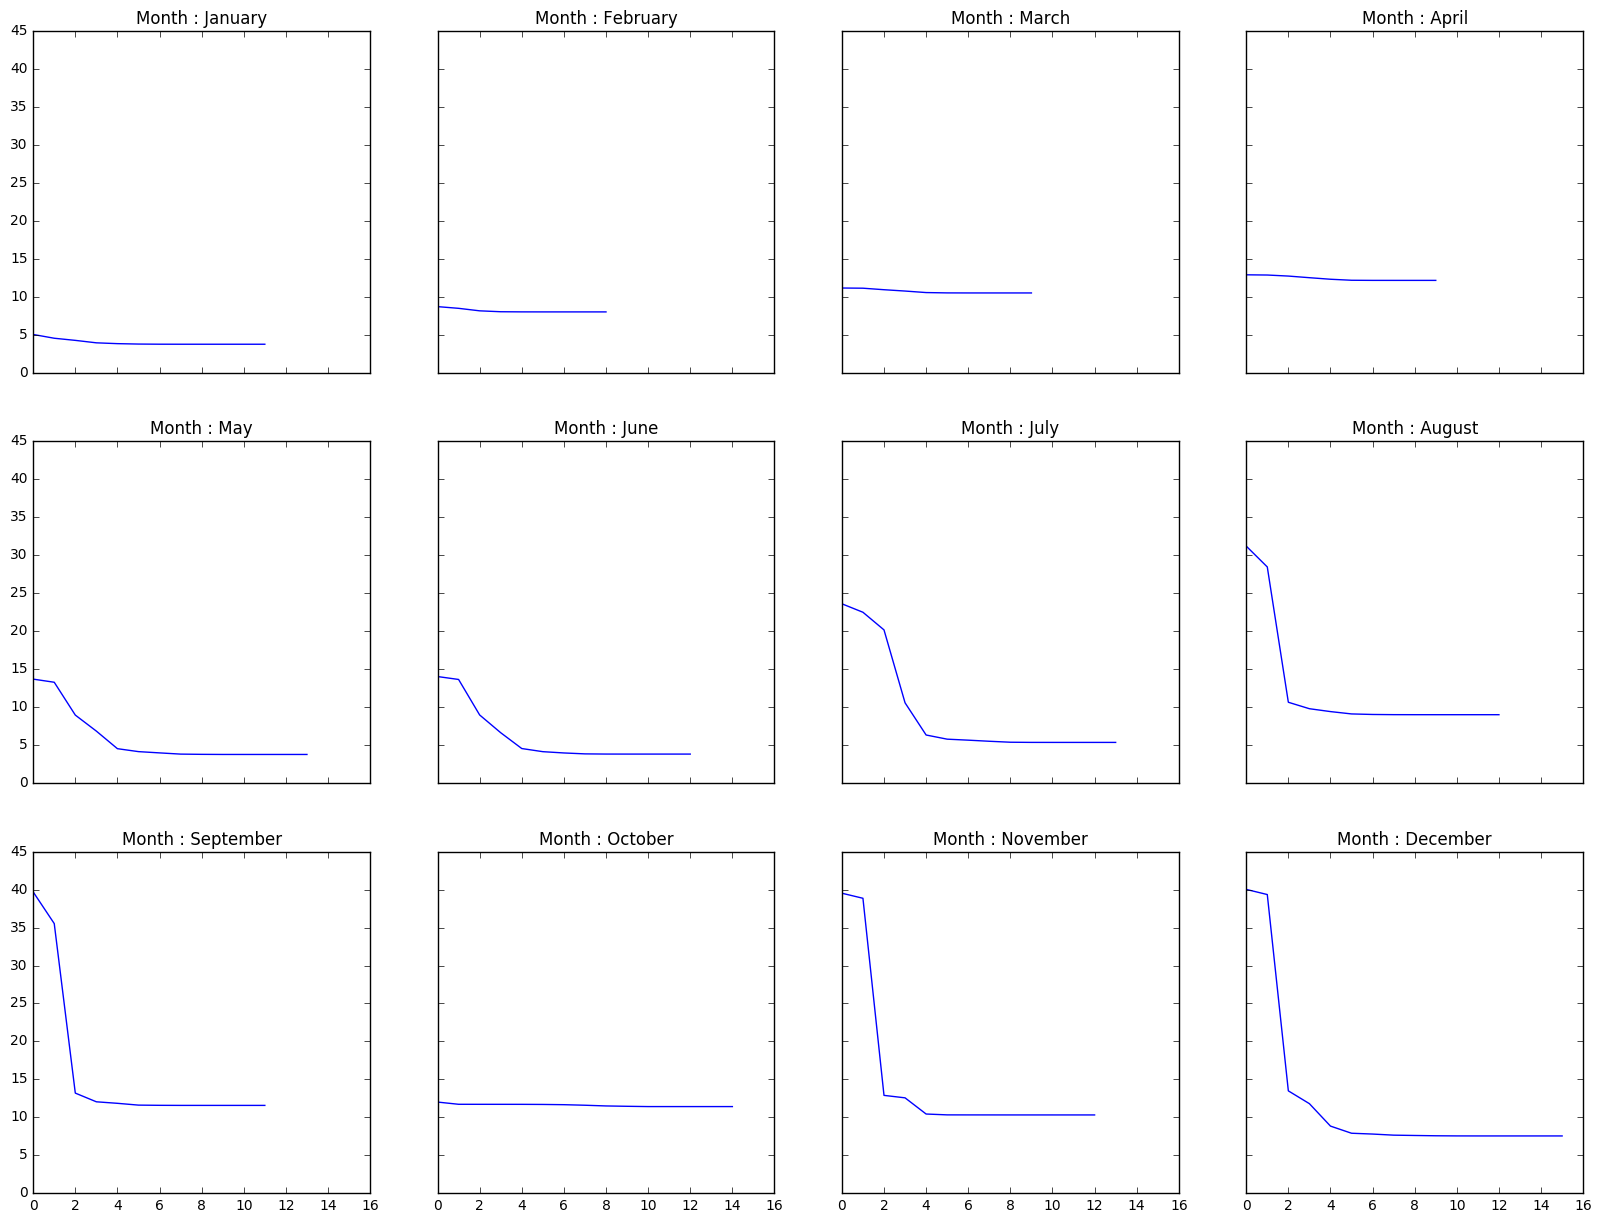

In [240]:
fig, axes = plt.subplots(figsize = (20,15),nrows=3, ncols=4, sharex=True, sharey=True)

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
for i in range(len(inpectors)):
    ins = inpectors[i]
#     print(np.array(ins.obj)[:, 0])
    ax = axes[int(i/4),i - int(i/4)*4].plot(np.array(ins.obj)[:, 0])
    axes[int(i/4),i - int(i/4)*4].set_title('Month : ' + months[i])


In [104]:
df_final_4 = FINAL[~FINAL.ASS_ASSIGNMENT.isin(['Téléphonie'])]
df_final_4 = df_final_4.rename(index=str, columns={"prediction_y": "prediction"})
df_final_4 = df_final_4.fillna(0)

# print(df_final_4[22700:22800])

In order to provide a complete submission we concatenate the result for Téléphonie (df_final_5) to the the one of the L-BFGS striped from Téléphonie (df_final_4

In [191]:
df_final_3 = pd.concat([df_final_5, df_final_4])
# print(df_final)
# print(df_final_4)
# print(df_final_3[26700:26800])
'''saving file '''
file_name = "submission"+str(datetime.datetime.now().strftime('%Y%m%d %H%M%S'))+".txt"
df_final_3.to_csv(	file_name, header=True, index=None, sep='\t', mode='a')